<h1 style="color: orange">[Projet] Chatbot de réservation de voyages</h1>

<img src="img/logo-entreprise.png" alt="logo entreprise" width="350">

# Sommaire

[1. Imports](#1.-Imports)<br><br>
[2. Analyse du jeu de données](#2.-Analyse-du-jeu-de-données)<br><br>
[3. LUIS](#3.-LUIS)
>[3.1 Extraction des données conversationnelles](#3.1-Extraction-des-données-conversationnelles)<br>
>[3.2 Création, entraînement et test du modèle LUIS](#3.2-Création,-entraînement-et-test-du-modèle-LUIS)

# 1. Imports

In [1]:
import os
import time
import json
import tqdm
import urllib
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from azure.cognitiveservices.language.luis.authoring.models import ExampleLabelObject
from azure.cognitiveservices.language.luis.authoring.models import EntityLabelObject
from azure.cognitiveservices.language.luis.authoring import LUISAuthoringClient
from azure.cognitiveservices.language.luis.runtime import LUISRuntimeClient
from msrest.authentication import CognitiveServicesCredentials

# 2. Analyse du jeu de données

In [2]:
conv = pd.read_json('data/frames.json')

### Contenu

In [5]:
conv.shape

(1369, 5)

In [4]:
conv.head()

,user_id,turns,wizard_id,id,labels
0,U22HTHYNP,[{'text': 'I'd like to book a trip to Atlantis...,U21DKG18C,e2c0fc6c-2134-4891-8353-ef16d8412c9a,"{'userSurveyRating': 4.0, 'wizardSurveyTaskSuc..."
1,U21E41CQP,"[{'text': 'Hello, I am looking to book a vacat...",U21DMV0KA,4a3bfa39-2c22-42c8-8694-32b4e34415e9,"{'userSurveyRating': 3.0, 'wizardSurveyTaskSuc..."
2,U21RP4FCY,[{'text': 'Hello there i am looking to go on a...,U21E0179B,6e67ed28-e94c-4fab-96b6-68569a92682f,"{'userSurveyRating': 2.0, 'wizardSurveyTaskSuc..."
3,U22HTHYNP,[{'text': 'Hi I'd like to go to Caprica from B...,U21DKG18C,5ae76e50-5b48-4166-9f6d-67aaabd7bcaa,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
4,U21E41CQP,"[{'text': 'Hello, I am looking to book a trip ...",U21DMV0KA,24603086-bb53-431e-a0d8-1dcc63518ba9,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."


### Description

In [6]:
conv.describe(include='all')

,user_id,turns,wizard_id,id,labels
count,1369,1369,1369,1369,1369
unique,11,1369,12,1369,16
top,U22K1SX9N,[{'text': 'I'd like to book a trip to Atlantis...,U21T9NMKM,e2c0fc6c-2134-4891-8353-ef16d8412c9a,"{'userSurveyRating': 5.0, 'wizardSurveyTaskSuc..."
freq,345,1,301,1,929


### Contenu d'une conversation

In [7]:
conv.iloc[0, 1]

[{'text': "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
  'labels': {'acts': [{'args': [{'val': 'book', 'key': 'intent'}],
     'name': 'inform'},
    {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
      {'val': 'Caprica', 'key': 'or_city'},
      {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
      {'val': '8', 'key': 'n_adults'},
      {'val': '1700', 'key': 'budget'}],
     'name': 'inform'}],
   'acts_without_refs': [{'args': [{'val': 'book', 'key': 'intent'}],
     'name': 'inform'},
    {'args': [{'val': 'Atlantis', 'key': 'dst_city'},
      {'val': 'Caprica', 'key': 'or_city'},
      {'val': 'Saturday, August 13, 2016', 'key': 'str_date'},
      {'val': '8', 'key': 'n_adults'},
      {'val': '1700', 'key': 'budget'}],
     'name': 'inform'}],
   'active_frame': 1,
   'frames': [{'info': {'intent': [{'val': 'book', 'negated': False}],
      'budget': [{'val': '1700.0', 'negated': False}],

### Rating (labels)

In [8]:
conv.iloc[0, 4]

{'userSurveyRating': 4.0, 'wizardSurveyTaskSuccessful': True}

In [10]:
conv['rating'] = conv['labels'].apply(lambda x: x['userSurveyRating'])

In [12]:
conv['rating'].describe()

count    1366.000000
mean        4.573419
std         0.839596
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

<AxesSubplot: >

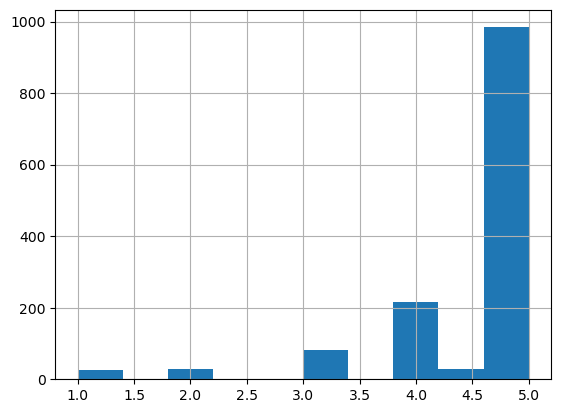

In [11]:
conv['rating'].hist()

[*(Retour sommaire)*](#Sommaire)

***

# 3. LUIS

## 3.1 Extraction des données conversationnelles

### Fonctions

In [3]:
def get_turn_entities(data, index, ls_entities):
    """
    Extrait les messages clients des frames du jeu de données sur la ligne indiquée
        @param data <Pandas.DataFrame> : les données JSON initiales chargées dans un DataFrame
        @param index <int> : la ligne du DataFrame à traiter
        @param ls_entities <list> : liste des entitées à rechercher dans les mesages
        @return <dict> : un dictionnaire d'utterances pour schéma LUIS {text, intent, entities} pour la ligne index
    """
    luis_data = []
    for conversation in data["turns"][index]:
        json_part = {}
        txt = conversation["text"].lower()
        json_part["text"] = txt
        json_part["intent"] = "BookFlight"
        # Nous n'utilisons que ce qu'ont écrit les utilisateurs
        if conversation["author"] == "user":
            for act in conversation["labels"]["acts"]:
                entities = []
                for arg in act["args"]:
                    if arg["key"] in ls_entities:
                        entity = {}
                        key = arg["key"].lower()
                        if "val" in arg.keys():
                            val = arg["val"].lower()
                            if val != "-1":
                                startCharIndex = txt.find(val)
                                endCharIndex = startCharIndex + len(val) - 1
                                entity["entity"] = key
                                entity["startPos"] = startCharIndex
                                entity["endPos"] = endCharIndex
                                if not ((key in ['str_date', 'end_date']) & (endCharIndex - startCharIndex < 4)):
                                    entities.append(entity)
                json_part["entities"] = entities
                
        if (len(json_part)>0):
            if "entities" in json_part.keys():
                if len(json_part["entities"]) > 0:
                    luis_data.append(json_part)
    return luis_data

In [4]:
def convert_data(data, ls_entities):
    """
    Compile dans une liste les extractions de messages clients à partir des frames fournis
        @param data <Pandas.DataFrame> : les données JSON initiales chargées dans un DataFrame
        @param ls_entities <list> : liste des entitées à rechercher dans les mesages
        @return <list> : une liste d'utterances à charger dans un schéma JSON pour LUIS
    """
    luis_data = []
    for i in range(data.shape[0]):
        json_part = get_turn_entities(data, i, ls_entities)
        if len(json_part)>0:
            for j in range(len(json_part)):
                luis_data.append(json_part[j])
    return luis_data

### Constitution du schéma

On indique les entitées à rechercher dans les messages client

In [5]:
luis_entities = [
    "or_city",
    "dst_city",
    "str_date",
    "end_date",
    "budget"
]

On fait appelle à la fonction de conversion qui transforme la totalité des messages clients en utterances

In [6]:
luis_data = convert_data(conv, luis_entities)

In [7]:
np.shape(luis_data)

(4067,)

In [95]:
luis_data[:5]

[{'text': "i'd like to book a trip to atlantis from caprica on saturday, august 13, 2016 for 8 adults. i have a tight budget of 1700.",
  'intent': 'BookFlight',
  'entities': [{'entity': 'dst_city', 'startPos': 27, 'endPos': 34},
   {'entity': 'or_city', 'startPos': 41, 'endPos': 47},
   {'entity': 'str_date', 'startPos': 52, 'endPos': 76},
   {'entity': 'budget', 'startPos': 117, 'endPos': 120}]},
 {'text': 'yes, how about going to neverland from caprica on august 13, 2016 for 5 adults. for this trip, my budget would be 1900.',
  'intent': 'BookFlight',
  'entities': [{'entity': 'dst_city', 'startPos': 24, 'endPos': 32},
   {'entity': 'budget', 'startPos': 114, 'endPos': 117}]},
 {'text': 'what about a trip from gotham city to neverland for the same budget?',
  'intent': 'BookFlight',
  'entities': [{'entity': 'dst_city', 'startPos': 38, 'endPos': 46},
   {'entity': 'or_city', 'startPos': 23, 'endPos': 33}]},
 {'text': 'would any packages to mos eisley be available if i increase my b

Constitution des jeu d'entraînement et de test

In [8]:
train_set = luis_data[:-40]
test_set = luis_data[-40:]
print(f"Longueur du Train set : {len(train_set)}")
print(f"Longueur du Test set : {len(test_set)}")

Longueur du Train set : 4027
Longueur du Test set : 40


Sauvegarde du schéma d'entraînement en cas d'utilisation du LUIS portal (création d'App via import JSON)

In [8]:
json_dict = {
  "luis_schema_version": "3.2.0",
  "versionId": "0.1",
  "name": "Airline Reservation",
  "desc": "A LUIS model that uses intent and entities.",
  "culture": "en-us",
  "tokenizerVersion": "1.0.0",
  "intents": [
    {
        "name": "BookFlight"
    },
    {
        "name": "None"
    }
  ],
  "entities": [
    {
        "name": "or_city",
        "roles": []
    },
    {
        "name": "dst_city",
        "roles": []
    },
    {
        "name": "str_date",
        "roles": []
    },
    {
        "name": "end_date",
        "roles": []
    },
    {
        "name": "budget",
        "roles": []
    }
  ],
  "composites": [],
  "closedLists": [],
  "patternAnyEntities": [],
  "regex_entities": [],
  "prebuiltEntities": [
    {
        "name": "datetimeV2",
        "roles": []
    },
    {
        "name": "geographyV2",
        "roles": []
    },
    {
        "name": "money",
        "roles": []
    },
  ],
  "model_features": [],
  "regex_features": [],
  "patterns": [],
  "utterances": [],
  "settings": []
}

In [9]:
json_dict["utterances"] = train_set

In [10]:
with open("data/luis_schema.json", "w") as f:
    json.dump(json_dict, f)

[*(Retour sommaire)*](#Sommaire)

***

## 3.2 Création, entraînement et test du modèle LUIS

### Fonctions

In [11]:
def booking_app(subscription_key, ms_region, entities, utterances):
    """
    Crée une nouvelle application LUIS de réservation de vol
        @param subscription_key <str> : le nom de la variable d'environnement contenant la clef de compte LUIS.ai
        @return <str> : l'endpoint de test du modèle
    """
    # Création du client LUIS
    client = LUISAuthoringClient(
        f'https://{ms_region}.api.cognitive.microsoft.com',
        CognitiveServicesCredentials(subscription_key))
    
    try:
        # Création de l'App LUIS
        default_app_name = "FlyMe-{}".format(datetime.datetime.now())
        version_id = "0.1"
        print(f"Creating LUIS App {default_app_name}, version {version_id}")
        app_id = client.apps.add({
            'name': default_app_name,
            'initial_version_id': version_id,
            'description': "New LUIS flight booking App created with Python",
            'culture': 'en-us',
        })
        print(f"Created App {app_id}")

        # Ajout des entités
        for e in entities:
            entity_id = client.model.add_entity(app_id, version_id, e)
            print(f"'{e}' simple entity created with id {entity_id}")
        client.model.add_prebuilt(app_id, version_id, prebuilt_extractor_names=["datetimeV2", "geographyV2", "money"])
        
        # Ajout des intentions
        client.model.add_intent(app_id, version_id, "BookFlight")
        client.model.add_custom_prebuilt_intent(app_id, version_id, domain_name="Utilities", model_name="Stop")
        client.model.add_custom_prebuilt_intent(app_id, version_id, domain_name="Utilities", model_name="Cancel")
        print("'Bookflight', 'Cancel' and 'Stop' intents created")

        # Ajout des utterances
        batch_size = 100
        steps = int(np.ceil(len(utterances) / batch_size))
        print(f"Adding the utterances in {steps} batches of {batch_size} examples each...")
        for i in tqdm.tqdm(range(steps)):
            ex = []
            start_idx = i * batch_size
            end_idx = min((i * batch_size) + batch_size, len(train_set))
            for u in utterances[start_idx:end_idx]:
                labels = []
                for e in u['entities']:
                    labels.append(EntityLabelObject(
                        entity_name=e['entity'],
                        start_char_index=e['startPos'],
                        end_char_index=e['endPos']
                    ))
                ex.append(ExampleLabelObject(text=u['text'], intent_name=u['intent'], entity_labels=labels))
            client.examples.batch(app_id, version_id, ex)
        print(f"{len(utterances)} utterances added to the 'BookFlight' intent")

        # Entraînement du modèle
        print("Starting training the App...")
        async_training = client.train.train_version(app_id, version_id)
        is_trained = async_training.status == "UpToDate"
        trained_status = ["UpToDate", "Success"]
        while not is_trained:
            time.sleep(1)
            status = client.train.get_status(app_id, version_id)
            is_trained = all(
                m.details.status in trained_status for m in status)
        print("Training complete")

        # Publication de l'App
        print("Starting publishing the App...")
        publish_result = client.apps.publish(app_id, version_id, is_staging=False)
        endpoint = publish_result.endpoint_url + "?subscription-key=" + subscription_key + "&q="
        print("Publishing complete")
        print(f"App testing endpoint : {endpoint}")
        
        return endpoint

    except Exception as err:
        print("Encountered exception. {}".format(err))

### Exécution du script de création / entraînement / mise en production

In [12]:
%%time
subscription_key = os.environ["LUIS_SUBSCRIPTION_KEY"]
ms_region = 'westeurope'
test_endpoint = booking_app(subscription_key, ms_region, luis_entities, train_set)

Creating LUIS App FlyMe-2022-11-08 18:33:01.777853, version 0.1
Created App 54f4df2a-6524-461f-8eb2-7fa061eb7450
'or_city' simple entity created with id 629c1c7b-1b2b-484a-b4ff-ec96620b71b3
'dst_city' simple entity created with id 035e32f9-c5fa-4bad-8aca-30bf1474b41a
'str_date' simple entity created with id 57d5446f-692d-4637-9838-d0115b35af17
'end_date' simple entity created with id fdcc7d37-276c-4355-b25e-c749809973de
'budget' simple entity created with id b454a91c-d31e-4969-813e-3caf110b8b52
'Bookflight', 'Cancel' and 'Stop' intents created
Adding the utterances in 41 batches of 100 examples each...


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:21<00:00,  1.94it/s]


4027 utterances added to the 'BookFlight' intent
Starting training the App...
Training complete
Starting publishing the App...
Publishing complete
App testing endpoint : https://westeurope.api.cognitive.microsoft.com/luis/v2.0/apps/54f4df2a-6524-461f-8eb2-7fa061eb7450?subscription-key=dbc6f189c1124c829d47049894a4d158&q=
CPU times: total: 6 s
Wall time: 49.6 s


### Test

Nous allons boucler sur les lignes du jeu de test et récupérer les évaluations intent/entities prédites par LUIS pour les comparer à la réalité.

In [177]:
def prediction_test(rest_query, test_set):
    """
    Réalise une série de prédictions et compile des métriques de justesse
        @param rest_query <str> : une chaîne de caractère telle que celle renvoiyer lors du déploiement et
            destinée à une requête GET contenant l'URL de l'endpoint de prédiction, la version d'API, 
            la clef d'application, la clef de souscription, et enfin le texte à tester
        @param test_set <dict> : un dictionnaire imbriqué de type JSON au format du schéma d'import LUIS portal,
            tel que défini sur la documentation de Microsoft :
            https://learn.microsoft.com/en-us/azure/cognitive-services/luis/app-schema-definition
        @return <int>, <Pandas.DataFrame> :
            - nombre de requêtes ayant échoué
            - DataFrame contenant des statistiques de justesse de prédiction sur le test_set : intent, entités
            et leur position dans le texte
    """
    # Les arrays récoltent les statistiques, la variable http_errors indique le nombre de requêtes ayant échoué
    stat_intent = []
    stat_entities = []
    stat_positions = []
    http_errors = 0
    
    for t in tqdm.tqdm(test_set):
        # Envoi de la requête
        url =  rest_query + urllib.parse.quote(t['text'])
        prediction = requests.get(url)
        if prediction.status_code != 200:
            http_errors += 1
            continue
        json = prediction.json()
            
        # Intent
        pred_intent = json['prediction']['topIntent']
        intent = t['intent']
        stat_intent.append(pred_intent == intent)
        
        # Entities
        if '$instance' in json['prediction']['entities'].keys():
            pred_entities = json['prediction']['entities']['$instance']
            entities = t['entities']
            nb_entities = len(entities)
            found_entities = 0
            found_positions = 0
            for e in entities:
                if e['entity'] in pred_entities:
                    found_entities += 1
                    if (e['startPos'] == pred_entities[e['entity']][0]['startIndex']) & (e['endPos'] == (pred_entities[e['entity']][0]['startIndex'] + pred_entities[e['entity']][0]['length'] - 1)) :
                        found_positions += 1
            stat_entities.append((found_entities / nb_entities) if (nb_entities != 0) else 0)
            stat_positions.append((found_positions / found_entities) if (found_entities != 0) else 0)
        else:
            stat_entities.append(0)
            stat_positions.append(0)
    
    # Compilation
    return pd.DataFrame({'intent_found': stat_intent, 'entity_rate': stat_entities, 'position_rate': stat_positions})

In [151]:
luis_query_string = "https://p10cognitivepred.cognitiveservices.azure.com/luis/prediction/v3.0/"\
    "apps/1a1df481-c2dd-4179-8654-7769a541386f/slots/production/predict?verbose=true&show-all-intents=true"\
    "&log=true&subscription-key=f910dac7fdbc43edae026ab1e2c0da60&query="

In [178]:
%%time
results = prediction_test(luis_query_string, test_set)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:08<00:00,  4.90it/s]

CPU times: total: 2.94 s
Wall time: 8.19 s


In [180]:
results

,intent_found,entity_rate,position_rate
0,True,1.000000,1.0
1,True,1.000000,1.0
2,True,1.000000,1.0
3,True,1.000000,1.0
4,True,1.000000,1.0
5,True,1.000000,1.0
6,True,1.000000,1.0
7,True,1.000000,1.0
8,True,1.000000,1.0
9,True,0.500000,0.0


In [183]:
intent_rate = np.round(len(results[results['intent_found'] == True]) * 100 / len(results), 2)
mean_entity_rate = np.round(results['entity_rate'].mean() * 100, 2)
mean_position_rate = np.round(results['position_rate'].mean() * 100, 2)
print(f"Pourcentage d'intentions correctement prédites : {intent_rate}%")
print(f"Pourcentage moyen d'entités correctement trouvées : {mean_entity_rate}%")
print(f"Pourcentage moyen d'entités correctement positionnées sur celles trouvées : {mean_position_rate}%")

Pourcentage d'intentions correctement prédites : 100.0%
Pourcentage moyen d'entités correctement trouvées : 90.42%
Pourcentage moyen d'entités correctement positionnées sur celles trouvées : 86.25%


[*(Retour sommaire)*](#Sommaire)

***